In [5]:
#making the correlation plot between evrery waveform

In [6]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import h5py
import glob 
from scipy import interpolate
import json
import os
import sys
from NuRadioReco.utilities import units
from NuRadioReco.detector import detector
from NuRadioMC.utilities import fluxes
from NuRadioMC.utilities.Veff import get_Veff_Aeff, get_Veff_Aeff_array, get_index, get_Veff_water_equivalent
#from my_Veff import get_Veff_Aeff, get_Veff_Aeff_array, get_index, get_Veff_water_equivalent
from NuRadioMC.examples.Sensitivities import E2_fluxes3 as limits
from Get_hdf5_data import get_attr_data, get_shower_data, get_station_data, get_Veff_data, get_event_data, get_nur_data
from Peak_Finding import count_peak, get_noise, save_data_2_csv, read_column_csv
import numpy as np
import matplotlib.pyplot as plt
from NuRadioReco.utilities import units
import NuRadioReco.detector.detector as detector
import NuRadioReco.modules.io.eventReader
import astropy
from NuRadioReco.framework.parameters import stationParameters as stnp
import pandas as pd
from math import isclose
import mplhep as hep

temp_stdout = None
# Disable
def blockPrint():
    global temp_stdout
    temp_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    global temp_stdout
    sys.stdout = temp_stdout


PATH = "/home/teikiet/Data/"
##########################################################################
S_ID = [100, 2, 3, 4, 5] #station ID
C_ID = list(range(0,16)) #channel ID
V_pole_channel = list(range(0,8)) #channel ID
H_pole_channel = list(range(8,16)) #channel ID
##########################################################################
E = 19 #energy
detectordescription = "detector/ara2.json" #detector 
##########################################################################

# data in csv file:
data1 = PATH + f'Peak_data/Data_monopoles_ara2_n1.000e04_1e{E}.csv'
data2 = PATH + f'Peak_data/Data_neutrinos_ara2_n1.000e04_1e{E}.csv'
data3 = PATH + f'Peak_data/Data_noise_ara2.csv'
##########################################################################
print(V_pole_channel)

[0, 1, 2, 3, 4, 5, 6, 7]


In [7]:
import ROOT 
import numpy as np
import matplotlib.pyplot as plt
import radiotools.helper

def correlation(channel1, channel2):
    return radiotools.helper.get_normalized_xcorr(channel1,channel2)
    
# Open the ROOT file for reading
file = "/home/teikiet/Data/grA_ev1_A4_2018_ie0_4096_T26Mar23-131515.979900_run4402.root"
root_file = ROOT.TFile(file, "READ")

keys = root_file.GetListOfKeys()
# Loop through the keys and identify TGraph objects
G_name = []
for key in keys:
    obj = key.ReadObj()
    if isinstance(obj, ROOT.TGraph):
        graph_name = key.GetName()
        G_name.append(graph_name)
print(G_name)
#Channel info for root file: ############################################################################################################
v_pole_channel_name = ['grCPAvg2M883_0', 'grCPAvgN_M128_0', 'grfftCPAvgN_M128_0', 'grCPAvg2M883_1', 'grCPAvgN_M128_1', 'grfftCPAvgN_M128_1', 'grCPAvg2M883_2', 'grCPAvgN_M128_2', 'grfftCPAvgN_M128_2', 'grCPAvg2M883_3', 'grCPAvgN_M128_3', 'grfftCPAvgN_M128_3', 'grCPAvg2M883_4', 'grCPAvgN_M128_4', 'grfftCPAvgN_M128_4', 'grCPAvg2M883_5', 'grCPAvgN_M128_5', 'grfftCPAvgN_M128_5', 'grCPAvg2M883_6', 'grCPAvgN_M128_6', 'grfftCPAvgN_M128_6', 'grCPAvg2M883_7', 'grCPAvgN_M128_7', 'grfftCPAvgN_M128_7']
h_pole_channel_name = ['grCPAvg2M883_8', 'grCPAvgN_M128_8', 'grfftCPAvgN_M128_8', 'grCPAvg2M883_9', 'grCPAvgN_M128_9', 'grfftCPAvgN_M128_9', 'grCPAvg2M883_10', 'grCPAvgN_M128_10', 'grfftCPAvgN_M128_10', 'grCPAvg2M883_11', 'grCPAvgN_M128_11', 'grfftCPAvgN_M128_11', 'grCPAvg2M883_12', 'grCPAvgN_M128_12', 'grfftCPAvgN_M128_12', 'grCPAvg2M883_13', 'grCPAvgN_M128_13', 'grfftCPAvgN_M128_13', 'grCPAvg2M883_14', 'grCPAvgN_M128_14', 'grfftCPAvgN_M128_14', 'grCPAvg2M883_15', 'grCPAvgN_M128_15', 'grfftCPAvgN_M128_15']

G_name = v_pole_channel_name

def read_root_file(root_file, graph_name):
    root_file = ROOT.TFile(root_file, "READ")
    # Get the TGraph by name
    graph = root_file.Get(graph_name)

    # Check if the TGraph exists
    if graph:
        # Access information about the TGraph
        n_points = graph.GetN()

        # Convert LowLevelViews to Python lists
        x_values = np.frombuffer(graph.GetX(), dtype=np.float64)
        y_values = np.frombuffer(graph.GetY(), dtype=np.float64)
        return int(graph_name[-1]), y_values
    else:
        print("TGraph", graph_name, "not found in the ROOT file.")
# Close the ROOT file when done
root_file.Close()

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
#Channel info: #############################################################################################################
v_pole_channel_info = [S_ID, V_pole_channel]
h_pole_channel_info = [S_ID, H_pole_channel]

#Get data:
def get_trigger_event(data, s_ID, c_ID):
    data_frame = pd.read_csv(data)
    event_id = np.array(data_frame["event"])
    num_of_events = event_id[-1]
    e_id = list(range(1, int(event_id[-1]+1)))
    data = []
    event_id = []
    noise = 1.0661514487245143e-05
    print("event_id", "station", "channel", "number of data")
    for i in range(len(e_id)):
        for station in s_ID:
            for channel in c_ID:
                trace_i = np.array(data_frame.query(f"station == {station} and channel == {channel} and event == {i}")['Traces']) 
                if len(trace_i) == 0:
                    pass
                else:
                    data_i = []
                    print(i, station, channel, len(trace_i))
                    trace_i = list(trace_i)
                    data_i.append(station)
                    data_i.append(channel)
                    data_i.append(trace_i)
                    ##############################
                    event_id.append(i)
                    data.append(data_i)
    return data
    
def found_indices(string, substring):    
    # Using a list comprehension
    found = [i for i, s in enumerate(strings) if substring in s]
    found = found[:3]
    return found
    
#Get trace:
def get_trace_from_data(channel_info):
    trace_neu =  get_trigger_event(data2, *channel_info)
    trace_mm =  get_trigger_event(data1, *channel_info)
    trace_noise =  get_trigger_event(data3, *channel_info)
    return trace_neu, trace_mm, trace_noise
def get_correlation(trace_neu, trace_mm, trace_noise, G_name):
    #neutrino to neutrino
    pairs_correlation_n2n = [max(correlation(np.array(trace_neu[i][2]), np.array(trace_neu[j][2])))
                            for i in range(len(trace_neu))
                            for j in range(i+1, len(trace_neu))
                            if trace_neu[i][0] == trace_neu[j][0] and trace_neu[i][1] == trace_neu[j][1]]
    #Monopole to monopole
    pairs_correlation_m2m = [max(correlation(np.array(trace_mm[i][2]), np.array(trace_mm[j][2])))
                            for i in range(len(trace_mm))
                            for j in range(i+1, len(trace_mm))
                            if trace_mm[i][0] == trace_mm[j][0]]
    #Neutrino to monopole
    pairs_correlation_n2m = [max(correlation(np.array(trace_neu[i][2]), np.array(trace_mm[j][2])))
                            for i in range(len(trace_neu))
                            for j in range(len(trace_mm))
                            if trace_neu[i][0] == trace_mm[j][0] and trace_neu[i][1] == trace_mm[j][1]]
    #Cal Pulser to neutrino
    pairs_correlation_c2n = [max(correlation(read_root_file(file, G_name[i])[1], np.array(trace_neu[j][2])))
                            for i in range(len(G_name))
                            for j in range(len(trace_neu))
                            if read_root_file(file, G_name[i])[0] == trace_neu[j][1]]
    #Cal Pulser to monopole
    pairs_correlation_c2m = [max(correlation(read_root_file(file, G_name[i])[1], np.array(trace_mm[j][2])))
                            for i in range(len(G_name))
                            for j in range(len(trace_mm))
                            if read_root_file(file, G_name[i])[0] == trace_mm[j][1]]

    #noise to noise:
    pairs_correlation_noise2noise = [max(correlation(np.array(trace_noise[i][2]), np.array(trace_noise[j][2])))
                                        for i in range(len(trace_noise))
                                        for j in range(i+1, len(trace_noise))
                                        if trace_noise[i][0] == trace_noise[j][0] and trace_noise[i][1] == trace_noise[j][1]]

    #noise to cal pulser:
    pairs_correlation_noise2c = [max(correlation(read_root_file(file, G_name[i])[1], np.array(trace_noise[j][2])))
                                        for i in range(len(G_name))
                                        for j in range(len(trace_noise))
                                        if read_root_file(file, G_name[i])[0] == trace_noise[j][1]]
    return pairs_correlation_n2n, pairs_correlation_m2m, pairs_correlation_n2m, pairs_correlation_c2n, pairs_correlation_c2m, pairs_correlation_noise2noise, pairs_correlation_noise2c


['grUBFFTAvg0_2018_439', 'grUBAvg0_2018_439', 'grUBFFTAvg1_2018_892', 'grUBAvg1_2018_892', 'grUBFFTAvg2_2018_439', 'grUBAvg2_2018_439', 'grUBFFTAvg3_2018_892', 'grUBAvg3_2018_892', 'grUBFFTAvg4_2018_892', 'grUBAvg4_2018_892', 'grUBFFTAvg5_2018_892', 'grUBAvg5_2018_892', 'grUBFFTAvg6_2018_892', 'grUBAvg6_2018_892', 'grUBFFTAvg7_2018_892', 'grUBAvg7_2018_892', 'grUBFFTAvg8_2018_439', 'grUBAvg8_2018_439', 'grUBFFTAvg9_2018_439', 'grUBAvg9_2018_439', 'grUBFFTAvg10_2018_439', 'grUBAvg10_2018_439', 'grUBFFTAvg11_2018_892', 'grUBAvg11_2018_892', 'grUBFFTAvg12_2018_439', 'grUBAvg12_2018_439', 'grUBFFTAvg13_2018_439', 'grUBAvg13_2018_439', 'grUBFFTAvg14_2018_439', 'grUBAvg14_2018_439', 'grUBFFTAvg15_2018_892', 'grUBAvg15_2018_892', 'grUBFFTAvg16_2018_892', 'grUBAvg16_2018_892', 'grUBFFTAvg17_2018_892', 'grUBAvg17_2018_892', 'grUBFFTAvg18_2018_892', 'grUBAvg18_2018_892', 'grUBFFTAvg19_2018_892', 'grUBAvg19_2018_892', 'grEvWf', 'grCPAvg2M883_0', 'grCPAvgN_M128_0', 'grfftCPAvgN_M128_0', 'grCPAvg2M

In [8]:
#get trace data:
trace_neu_v, trace_mm_v, trace_noise_v = get_trace_from_data(v_pole_channel_info)
trace_neu_h, trace_mm_h, trace_noise_h = get_trace_from_data(h_pole_channel_info)

event_id station channel number of data
1 2 0 3418
1 2 1 3418
1 2 2 3418
1 2 3 3418
1 2 4 3418
1 2 5 3418
1 2 6 3418
1 2 7 3418
2 5 0 1680
2 5 1 1680
2 5 2 1680
2 5 3 1680
2 5 4 1680
2 5 5 1680
2 5 6 1680
2 5 7 1680
3 2 0 2470
3 2 1 2470
3 2 2 2470
3 2 3 2470
3 2 4 2470
3 2 5 2470
3 2 6 2470
3 2 7 2470
4 4 0 2558
4 4 1 2558
4 4 2 2558
4 4 3 2558
4 4 4 2558
4 4 5 2558
4 4 6 2558
4 4 7 2558
5 4 0 1762
5 4 1 1762
5 4 2 1762
5 4 3 1762
5 4 4 1762
5 4 5 1762
5 4 6 1762
5 4 7 1762
6 100 0 1434
6 100 1 1434
6 100 2 1434
6 100 3 1434
6 100 4 1434
6 100 5 1434
6 100 6 1434
6 100 7 1434
7 5 0 1972
7 5 1 1972
7 5 2 1972
7 5 3 1972
7 5 4 1972
7 5 5 1972
7 5 6 1972
7 5 7 1972
8 3 0 1486
8 3 1 1486
8 3 2 1486
8 3 3 1486
8 3 4 1486
8 3 5 1486
8 3 6 1486
8 3 7 1486
9 100 0 1246
9 100 1 1246
9 100 2 1246
9 100 3 1246
9 100 4 1246
9 100 5 1246
9 100 6 1246
9 100 7 1246
10 2 0 1530
10 2 1 1530
10 2 2 1530
10 2 3 1530
10 2 4 1530
10 2 5 1530
10 2 6 1530
10 2 7 1530
11 3 0 1792
11 3 1 1792
11 3 2 1792
11 3

KeyboardInterrupt: 

/home/teikiet/.local/lib/python3.10/site-packages/radiotools/helper.py:826: RuntimeWarning: invalid value encountered in divide
  return correlate(trace1, trace2, mode=mode, method='auto') / (np.sum(trace1 ** 2) * np.sum(trace2 ** 2)) ** 0.5


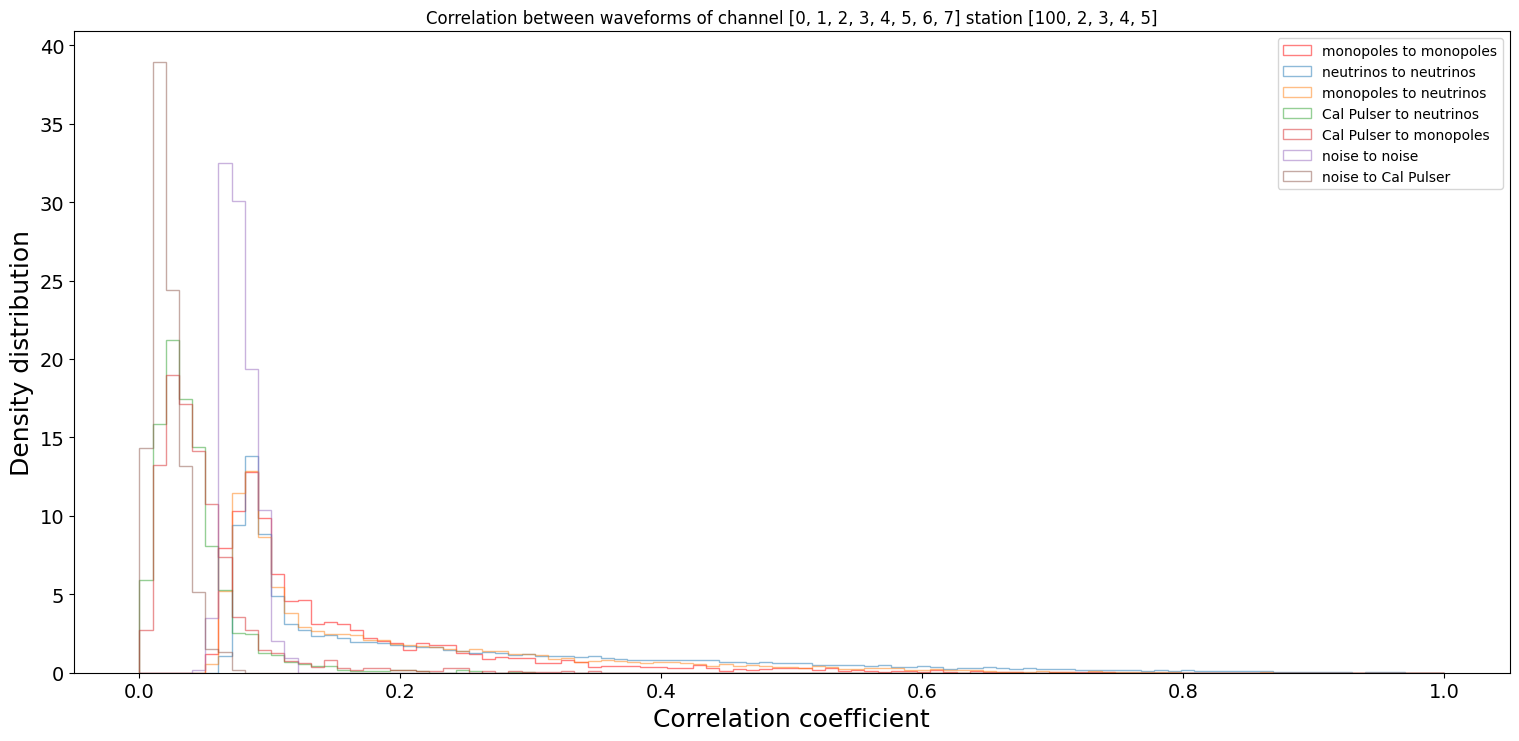

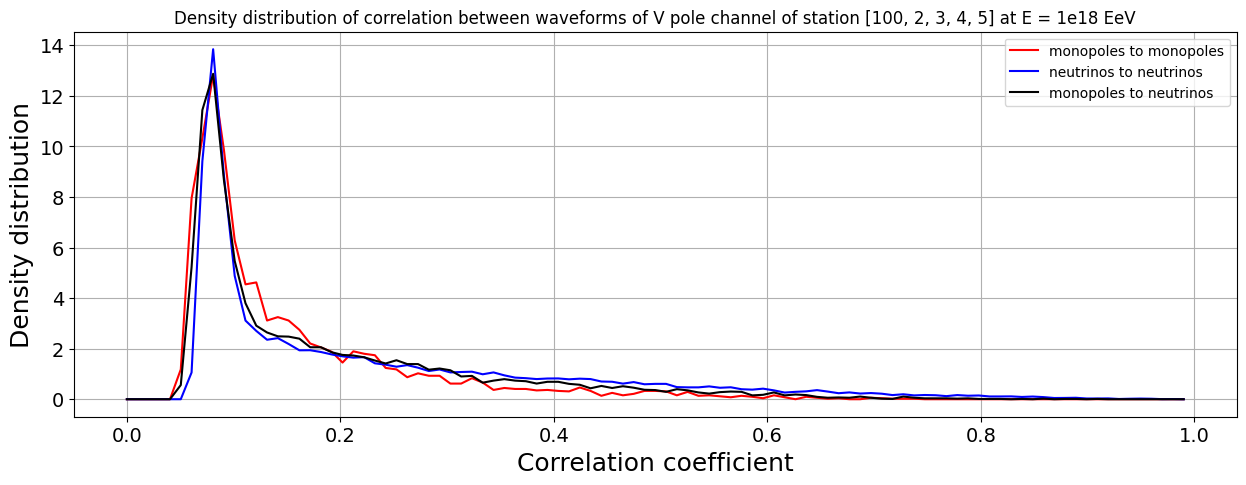

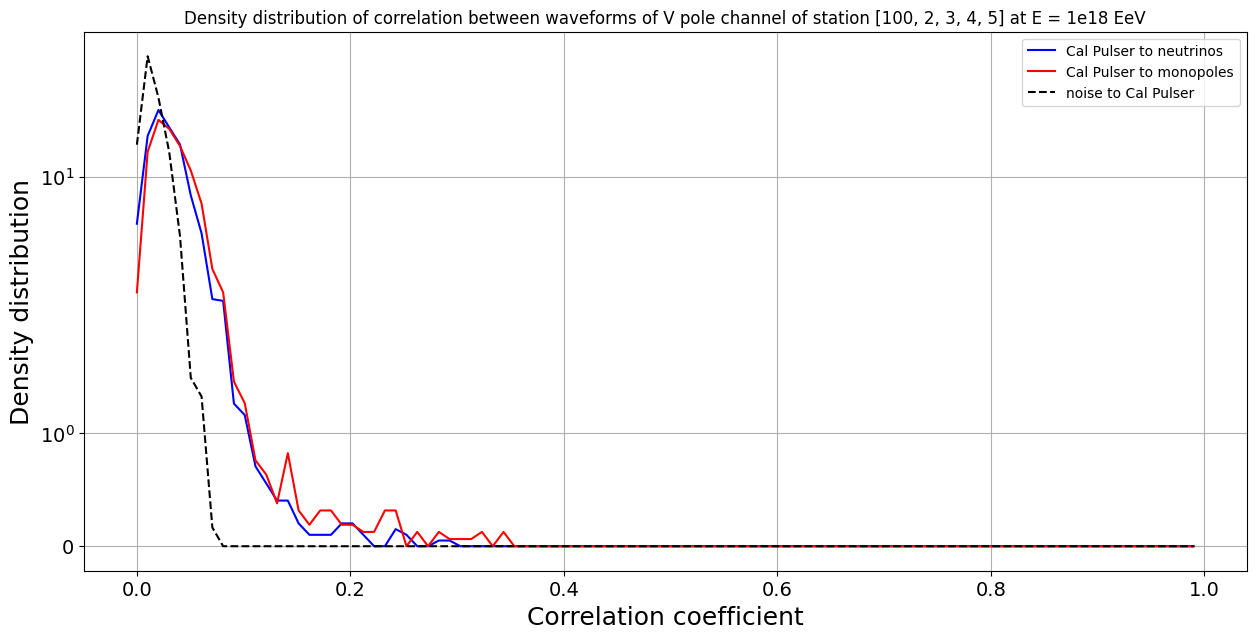

In [ ]:
#V_pole channel:
import numpy as np
import matplotlib.pyplot as plt

# Data for histograms
data1, data2, data3, data4, data5, data6, data7 = get_correlation(trace_neu_v, trace_mm_v, trace_noise_v, v_pole_channel_name)

# Determine the common bin edges
bin_min = 0
bin_max = 1
num_bins = 100
bin_edges = np.linspace(bin_min, bin_max, num_bins)
# Create a figure and set up subplots
plt.figure( figsize=(15, 7))

# Plot the first histogram with log scale on y-axis
h1 = plt.hist(data1, bins=bin_edges , histtype='step', stacked=True, fill=False, color='red', alpha=0.5, label='monopoles to monopoles', density=True)

h2 = plt.hist(data2, bins=bin_edges, histtype='step', stacked=True, fill=False, alpha=0.5, label='neutrinos to neutrinos', density=True)

h3 = plt.hist(data3, bins=bin_edges, histtype='step', stacked=True, fill=False, alpha=0.5, label='monopoles to neutrinos', density=True)

h4 = plt.hist(data4, bins=bin_edges, histtype='step', stacked=True, fill=False, alpha=0.5, label="Cal Pulser to neutrinos", density=True)

h5 = plt.hist(data5, bins=bin_edges, histtype='step', stacked=True, fill=False, alpha=0.5, label="Cal Pulser to monopoles", density=True)

h6 = plt.hist(data6, bins=bin_edges, histtype='step', stacked=True, fill=False, alpha=0.5, label="noise to noise", density=True)

h7 = plt.hist(data7, bins=bin_edges, histtype='step', stacked=True, fill=False, alpha=0.5, label="noise to Cal Pulser", density=True)
# Add labels and title to the figure
plt.tight_layout()
plt.xlabel('Correlation coefficient')
plt.ylabel('Density distribution')
#plt.yscale('log')
# Show the plot
plt.legend(loc='upper right')
plt.title(f'Correlation between waveforms of channel {channel_info[1]} station {channel_info[0]}')
plt.show()
plt.figure(figsize=(15, 5))
plt.errorbar(h1[1][:-1], h1[0], fmt='-', color='red', capsize=2, label='monopoles to monopoles')
plt.errorbar(h2[1][:-1], h2[0], fmt='-', color='blue', capsize=2 , label='neutrinos to neutrinos')
plt.errorbar(h3[1][:-1], h3[0], fmt='-', color='black', capsize=2 , label='monopoles to neutrinos')
#plt.errorbar(h6[1][:-1], h6[0], fmt='--', color='green', capsize=2 , label='noise to noise')

#plt.yscale('symlog')
#plt.xscale('log')
plt.grid()  
plt.legend(loc='upper right')
plt.xlabel('Correlation coefficient')
plt.ylabel('Density distribution')
plt.title(f'Density distribution of correlation between waveforms of V pole channel of station {channel_info[0]} at E = 1e{E} EeV')
plt.show()
plt.figure(figsize=(15, 7))
plt.errorbar(h4[1][:-1], h4[0], fmt='-', color='blue', capsize=2 , label='Cal Pulser to neutrinos')
plt.errorbar(h5[1][:-1], h5[0], fmt='-', color='red', capsize=2 , label='Cal Pulser to monopoles')
plt.errorbar(h7[1][:-1], h7[0], fmt='--', color='black', capsize=2 , label='noise to Cal Pulser')

plt.yscale('symlog')
#plt.xscale('log')
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Correlation coefficient')
plt.ylabel('Density distribution')
plt.title(f'Density distribution of correlation between waveforms of V pole channel of station {channel_info[0]} at E = 1e{E} EeV')
plt.show()


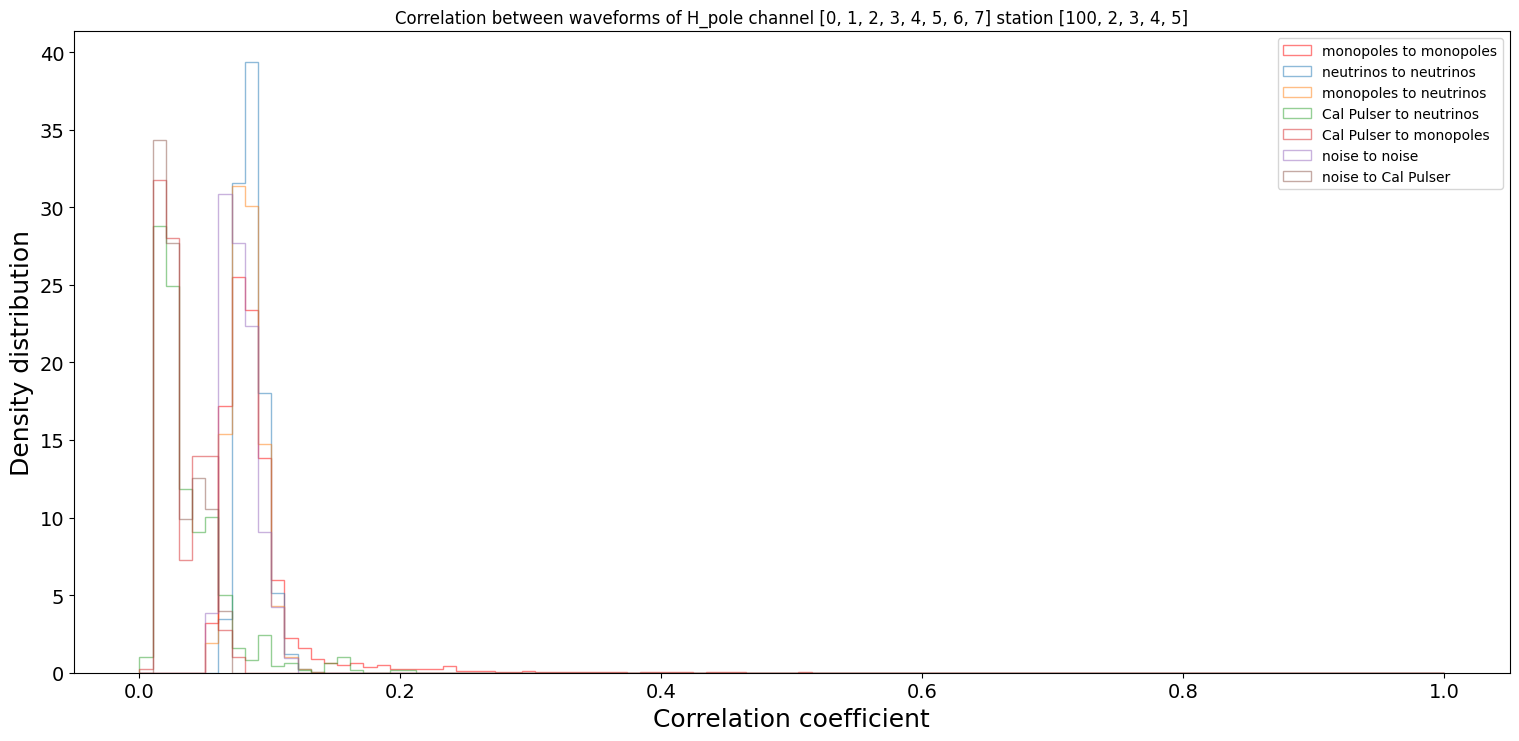

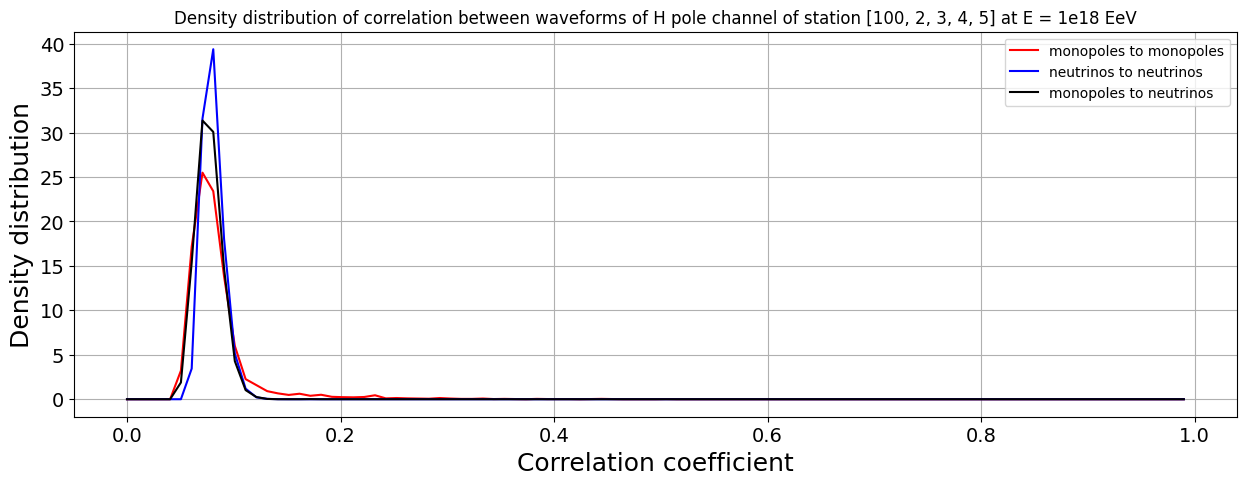

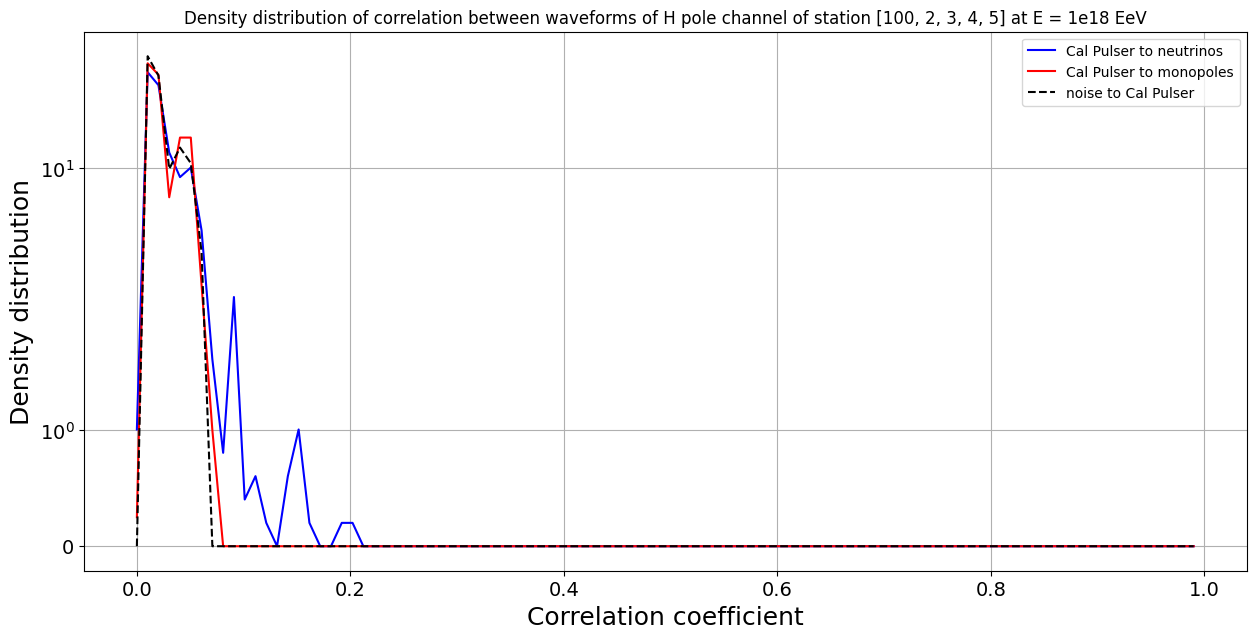

In [ ]:
#H pole channel:
import numpy as np
import matplotlib.pyplot as plt

# Data for histograms
data1, data2, data3, data4, data5, data6, data7 = get_correlation(trace_neu_h, trace_mm_h, trace_noise_h, h_pole_channel_name)

# Determine the common bin edges
bin_min = 0
bin_max = 1
num_bins = 100
bin_edges = np.linspace(bin_min, bin_max, num_bins)
# Create a figure and set up subplots
plt.figure( figsize=(15, 7))

# Plot the first histogram with log scale on y-axis
h1 = plt.hist(data1, bins=bin_edges , histtype='step', stacked=True, fill=False, color='red', alpha=0.5, label='monopoles to monopoles', density=True)

h2 = plt.hist(data2, bins=bin_edges, histtype='step', stacked=True, fill=False, alpha=0.5, label='neutrinos to neutrinos', density=True)

h3 = plt.hist(data3, bins=bin_edges, histtype='step', stacked=True, fill=False, alpha=0.5, label='monopoles to neutrinos', density=True)

h4 = plt.hist(data4, bins=bin_edges, histtype='step', stacked=True, fill=False, alpha=0.5, label="Cal Pulser to neutrinos", density=True)

h5 = plt.hist(data5, bins=bin_edges, histtype='step', stacked=True, fill=False, alpha=0.5, label="Cal Pulser to monopoles", density=True)

h6 = plt.hist(data6, bins=bin_edges, histtype='step', stacked=True, fill=False, alpha=0.5, label="noise to noise", density=True)

h7 = plt.hist(data7, bins=bin_edges, histtype='step', stacked=True, fill=False, alpha=0.5, label="noise to Cal Pulser", density=True)
# Add labels and title to the figure
plt.tight_layout()
plt.xlabel('Correlation coefficient')
plt.ylabel('Density distribution')
#plt.yscale('log')
# Show the plot
plt.legend(loc='upper right')
plt.title(f'Correlation between waveforms of H_pole channel {channel_info[1]} station {channel_info[0]}')
plt.show()
plt.figure(figsize=(15, 5))
plt.errorbar(h1[1][:-1], h1[0], fmt='-', color='red', capsize=2, label='monopoles to monopoles')
plt.errorbar(h2[1][:-1], h2[0], fmt='-', color='blue', capsize=2 , label='neutrinos to neutrinos')
plt.errorbar(h3[1][:-1], h3[0], fmt='-', color='black', capsize=2 , label='monopoles to neutrinos')
#plt.errorbar(h6[1][:-1], h6[0], fmt='--', color='green', capsize=2 , label='noise to noise')

#plt.yscale('symlog')
#plt.xscale('log')
plt.grid()  
plt.legend(loc='upper right')
plt.xlabel('Correlation coefficient')
plt.ylabel('Density distribution')
plt.title(f'Density distribution of correlation between waveforms of H pole channel of station {channel_info[0]} at E = 1e{E} EeV')
plt.show()
plt.figure(figsize=(15, 7))
plt.errorbar(h4[1][:-1], h4[0], fmt='-', color='blue', capsize=2 , label='Cal Pulser to neutrinos')
plt.errorbar(h5[1][:-1], h5[0], fmt='-', color='red', capsize=2 , label='Cal Pulser to monopoles')
plt.errorbar(h7[1][:-1], h7[0], fmt='--', color='black', capsize=2 , label='noise to Cal Pulser')

plt.yscale('symlog')
#plt.xscale('log')
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Correlation coefficient')
plt.ylabel('Density distribution')
plt.title(f'Density distribution of correlation between waveforms of H pole channel of station {channel_info[0]} at E = 1e{E} EeV')
plt.show()



In [ ]:
for i in range(len(trace_neu)):
    for j in range(i+1, len(trace_neu)):
        corr = max(correlation(np.array(trace_neu[i]), np.array(trace_neu[j])))
        if  corr > 1:
            #make side by side plot
            plt.figure(figsize=(15,2))
            plt.subplot(1,2,1)
            plt.plot(np.array(trace_neu[i]))
            plt.subplot(1,2,2)
            plt.plot(np.array(trace_neu[j]))
            plt.title(f"corr = {corr}")
            plt.show()
            

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [ ]:
for i in range(len(trace_neu)):
    for j in range(len(trace_mm)):
        corr = max(correlation(np.array(trace_neu[i]), np.array(trace_mm[j])))
        if corr >1:
            #make side by side plot
            plt.figure(figsize=(15,2))
            plt.subplot(1,2,1)
            plt.plot(np.array(trace_neu[i]))
            plt.subplot(1,2,2)
            plt.plot(np.array(trace_mm[j]))
            plt.title(f"corr = {corr}")
            plt.show()
            

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [ ]:
for i in range(len(trace_mm)):
    for j in range(i+1, len(trace_mm)):
        corr = max(correlation(np.array(trace_mm[i]), np.array(trace_mm[j])))
        if corr >1:
            #make side by side plot
            plt.figure(figsize=(15,2))
            plt.subplot(1,2,1)
            plt.plot(np.array(trace_mm[i]))
            plt.subplot(1,2,2)
            plt.plot(np.array(trace_mm[j]))
            plt.title(f"corr = {corr}")
            plt.show()
            